In [92]:
import tensorflow as tf
import pandas as pd
import numpy as np
import stellargraph as sg
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
import scipy.sparse as sp
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [53]:
# get the data into dataframes
edges = pd.read_csv("musae_facebook_edges.csv")
target = pd.read_csv("musae_facebook_target.csv")

In [54]:
edges

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
...,...,...
170997,20188,20188
170998,22340,22383
170999,22348,22348
171000,5563,5563


In [55]:
target

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
...,...,...,...,...
22465,22465,1379955382222841,Kurt Wiegel MdL,politician
22466,22466,1651527995097082,dubdub Stories,company
22467,22467,155369444540412,Ministerio del Interior - Paraguay,government
22468,22468,175067819212798,Tottus Perú,company


In [56]:
np_edges = np.load("edges.npy")
np_features = np.load("features.npy")
np_target = np.load("target.npy")
target.page_type.unique()

array(['tvshow', 'government', 'company', 'politician'], dtype=object)

In [78]:
print(np_edges.shape)
print(np_features.shape)
print(np_target.shape, np_target)

(342004, 2)
(22470, 128)
(22470,) [0 2 1 ... 2 1 0]


array([[    0, 18427],
       [18427,     0],
       [    1, 21708],
       ...,
       [ 5563,  5563],
       [22425, 22425],
       [22425, 22425]])

In [58]:
df_features = pd.DataFrame(np_features)
df_edges = pd.DataFrame(np_edges)
df_targets = pd.DataFrame(np_target)
df_edges.columns = ["source", "target"]
df_targets.columns = ["target"]
mat = sg.StellarGraph(df_features, df_edges)
print (mat.info())

StellarGraph: Undirected multigraph
 Nodes: 22470, Edges: 342004

 Node types:
  default: [22470]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [342004]
        Weights: all 1 (default)
        Features: none


In [59]:
train_data, test_data = train_test_split(df_targets, train_size=500)
val_data, test_data = train_test_split(test_data, train_size=500)
print("train data: ",train_data.shape, "validation data: ",val_data.shape, 
      "test data: ",test_data.shape)
train_data.index

train data:  (500, 1) validation data:  (500, 1) test data:  (21470, 1)


Int64Index([16685,  1028,  5240,  8011, 14283,  5489,  9481,  3615,  2639,
               27,
            ...
            11689,  6267,   444,  7257, 18659, 15888, 15321,  1984, 12184,
            21084],
           dtype='int64', length=500)

In [60]:
one_hot_target = pre.LabelBinarizer()
train_targets = one_hot_target.fit_transform(train_data['target'])
val_targets = one_hot_target.transform(val_data['target'])
test_targets = one_hot_target.transform(test_data['target'])

print (test_targets.shape, val_targets.shape, train_targets.shape)


(21470, 4) (500, 4) (500, 4)


In [61]:
generator = FullBatchNodeGenerator(mat, method="gcn")
train_gen = generator.flow(train_data.index, train_targets)
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.2
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

Using GCN (local pooling) filters...


In [62]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
val_gen = generator.flow(val_data.index, val_targets)

In [63]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
history = model.fit(
    train_gen,
    epochs=150,
    validation_data=val_gen,
    verbose=2,
    shuffle=False, 
    callbacks=[es_callback],
)

Epoch 1/150
1/1 - 1s - loss: 1.3755 - acc: 0.2920 - val_loss: 1.2702 - val_acc: 0.4420
Epoch 2/150
1/1 - 0s - loss: 1.2246 - acc: 0.4740 - val_loss: 1.1605 - val_acc: 0.5420
Epoch 3/150
1/1 - 0s - loss: 1.0982 - acc: 0.5600 - val_loss: 1.0668 - val_acc: 0.5620
Epoch 4/150
1/1 - 0s - loss: 0.9963 - acc: 0.6020 - val_loss: 0.9804 - val_acc: 0.6140
Epoch 5/150
1/1 - 0s - loss: 0.8942 - acc: 0.6500 - val_loss: 0.9012 - val_acc: 0.6440
Epoch 6/150
1/1 - 0s - loss: 0.8109 - acc: 0.6540 - val_loss: 0.8270 - val_acc: 0.6820
Epoch 7/150
1/1 - 0s - loss: 0.7428 - acc: 0.7080 - val_loss: 0.7565 - val_acc: 0.7060
Epoch 8/150
1/1 - 0s - loss: 0.6534 - acc: 0.7560 - val_loss: 0.6894 - val_acc: 0.7440
Epoch 9/150
1/1 - 0s - loss: 0.6008 - acc: 0.7880 - val_loss: 0.6289 - val_acc: 0.7740
Epoch 10/150
1/1 - 0s - loss: 0.5268 - acc: 0.8220 - val_loss: 0.5779 - val_acc: 0.8020
Epoch 11/150
1/1 - 0s - loss: 0.4895 - acc: 0.8260 - val_loss: 0.5381 - val_acc: 0.8200
Epoch 12/150
1/1 - 0s - loss: 0.4410 - ac

Epoch 95/150
1/1 - 0s - loss: 0.0288 - acc: 0.9960 - val_loss: 0.8789 - val_acc: 0.8800
Epoch 96/150
1/1 - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.8788 - val_acc: 0.8800
Epoch 97/150
1/1 - 0s - loss: 0.0226 - acc: 0.9940 - val_loss: 0.8784 - val_acc: 0.8840
Epoch 98/150
1/1 - 0s - loss: 0.0202 - acc: 0.9920 - val_loss: 0.8769 - val_acc: 0.8800
Epoch 99/150
1/1 - 0s - loss: 0.0207 - acc: 0.9940 - val_loss: 0.8716 - val_acc: 0.8800
Epoch 100/150
1/1 - 0s - loss: 0.0217 - acc: 0.9940 - val_loss: 0.8709 - val_acc: 0.8760
Epoch 101/150
1/1 - 0s - loss: 0.0319 - acc: 0.9940 - val_loss: 0.8742 - val_acc: 0.8780
Epoch 102/150
1/1 - 0s - loss: 0.0068 - acc: 1.0000 - val_loss: 0.8786 - val_acc: 0.8820
Epoch 103/150
1/1 - 0s - loss: 0.0303 - acc: 0.9960 - val_loss: 0.8838 - val_acc: 0.8800
Epoch 104/150
1/1 - 0s - loss: 0.0171 - acc: 0.9900 - val_loss: 0.8862 - val_acc: 0.8780
Epoch 105/150
1/1 - 0s - loss: 0.0168 - acc: 0.9920 - val_loss: 0.8859 - val_acc: 0.8760
Epoch 106/150
1/1 - 0s - l

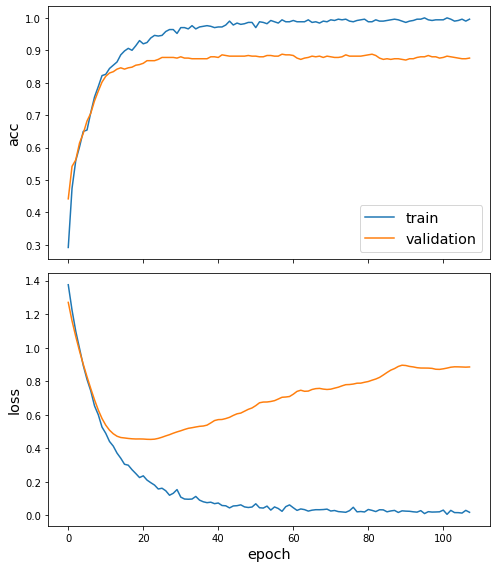

In [64]:
sg.utils.plot_history(history)

In [83]:
test_gen = generator.flow(test_data.index, test_targets)
test_metrics = model.evaluate(test_gen)
print (df_targets.index)

1/1 [==============================] - 0s 92ms/step - loss: 0.6753 - acc: 0.8700
RangeIndex(start=0, stop=22470, step=1)


In [85]:
transform = TSNE
all_nodes = df_targets.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)


In [87]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
print(emb.shape)

(1, 22470, 32)


In [88]:
X = emb.squeeze(0)
X.shape

(22470, 32)

In [90]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(22470, 2)

<class 'pandas.core.frame.DataFrame'>


[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset')]

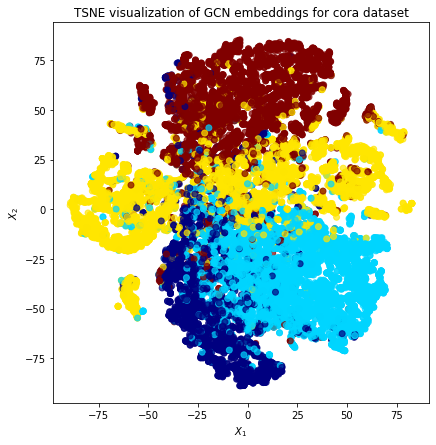

In [96]:

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df_targets.squeeze().astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)